# THE PROBLEM STATEMENT

*   For companies to become competitive, they need to develope predictive models which takes into account seasonality effects, demand, holidays, promotions etc... to forecast sales in the future.
*   In this project, I tried to predict future daily sales of Rossmann Stores given the historical sales data for 1,115 Stores of it using **Facebook Prophet** Intuition.

# IMPORT LIBRARIES AND DATASET 

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   We have two dataset for this study, one for Sales (the transactions recorded per day) and one for the Stores (information about the unique 1115 stores).
*   Data Source: https://www.kaggle.com/c/rossmann-store-sales/data

#### SALES TRAINING DATA

FEATURES
*   Id: transaction ID (combination of Store and date) 
*   Store: unique store Id
*   Sales: sales/day (in Euro), this is the target variable 
*   Customers: number of customers on a given day
*   Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
*   Promo: describes if store is running a promo on that day or not
*   StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
*   SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools

In [7]:
sales_train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data_Science_For_Business_Course/train.csv', low_memory=False)

In [8]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


*   1017209 total data points
*   9 columns in total (8 features, 1 target variable (sales))

In [10]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


*   Average sales amount per day = 5773 Euros, minimum sales per day = 0, maximum sales per day = 41551 
*   Average number of customers = 633, minimum number of customers = 0, maximum number of customers = 7388

#### STORE INFORMATION DATA

FEATURES
*   StoreType: categorical variable to indicate type of store (a, b, c, d)
*   Assortment: describes an assortment level: a = basic, b = extra, c = extended
*   CompetitionDistance (meters): distance to closest competitor store
*   CompetitionOpenSince [Month/Year]: provides an estimate of the date when competition was open
*   Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
*   Promo2Since [Year/Week]: date when the store started participating in Promo2
*   PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [11]:
store_info_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data_Science_For_Business_Course/store.csv')

In [12]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [14]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


# EXPLORE DATASET

### SALES TRAINING DATA

In [15]:
# Let's see if we have any missing data
sales_train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

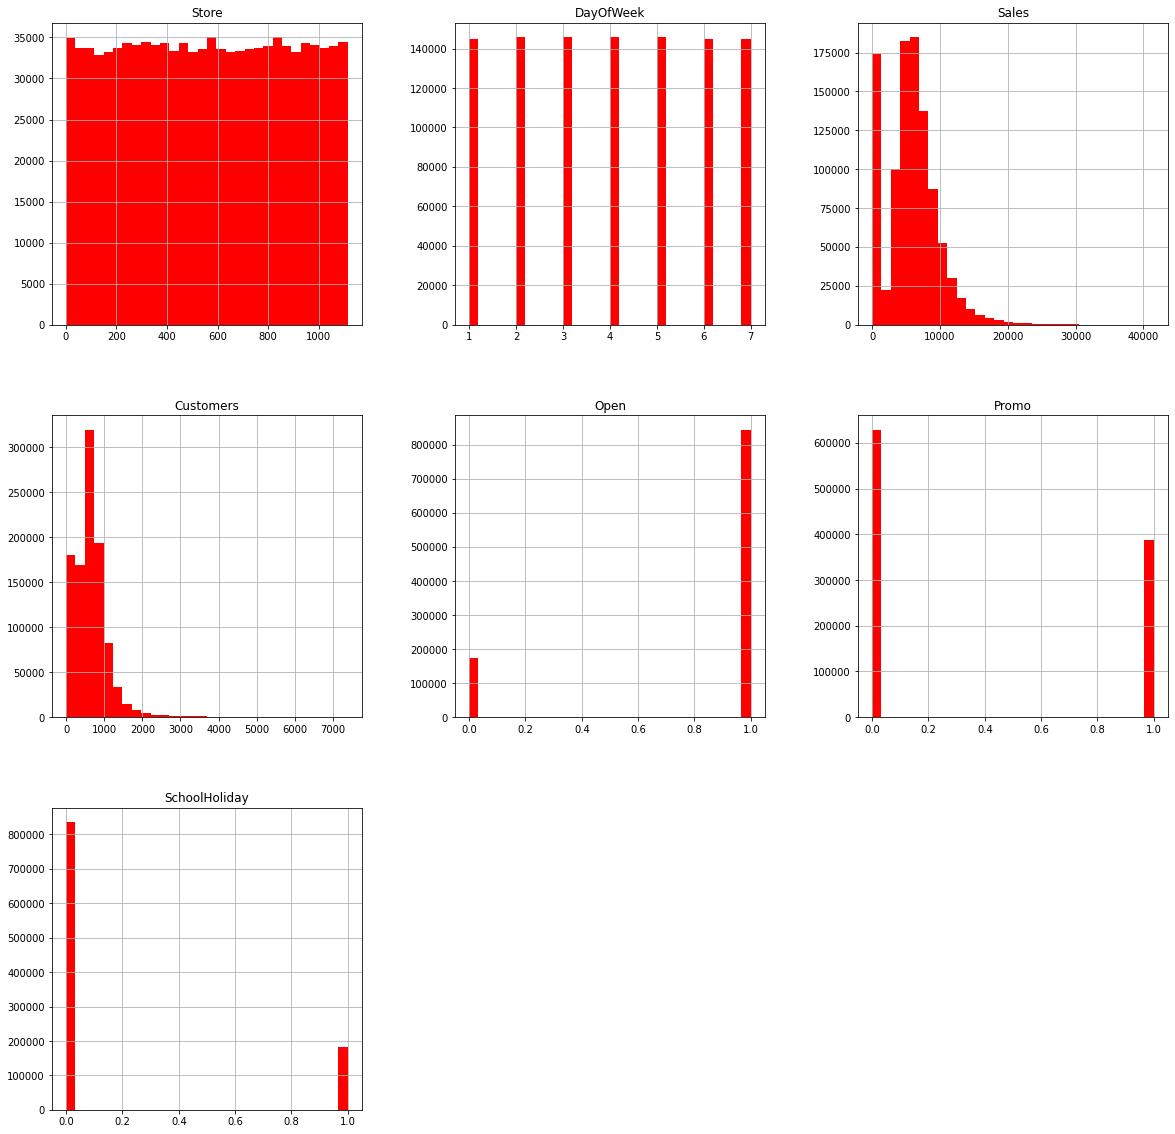

In [16]:
# Let's look at histograms
sales_train_df.hist(bins=30, figsize=(20,20), color='r')
plt.show()

**SOME OBSERVATIONS**
*   Because of the outliers number of Customers and Sales is positively skewed.
*   Data is equally distibuted across various Days of the week 
*   Stores are open ~80% of the time
*   Data is equally distributed among all stores (no bias)
*   Promo #1 was running ~40% of the time 
*   School holidays are around ~18% of the time

In [17]:
# Let's see how many stores are open and closed! 
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [18]:
# Count the number of stores that are open and closed
print("Total =", len(sales_train_df))
print("Number of closed stores =", len(closed_train_df))
print("Number of open stores =", len(open_train_df))

Total = 1017209
Number of closed stores = 172817
Number of open stores = 844392


In [19]:
# only keep open stores and remove closed stores (as closed one's most values are zero)
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [20]:
# Let's drop the open column since it has no meaning now
sales_train_df.drop(['Open'], axis=1, inplace=True)

In [21]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


*   As we drop closed stores, our statistics changes. Average sales went up to 6955 Euros and average number of customers became 762

###  STORES INFORMATION DATA

In [22]:
# Let's look at missing data
store_info_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [23]:
# Let's look at Promo2 missing values
store_info_df[store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


*   It seems like if 'promo2' is zero, 'promo2SinceWeek', 'Promo2SinceYear', and 'PromoInterval' information is also zero, which makes sense. So we can replace the NaN's with Zeros. Similarly 354 rows where 'CompetitionOpenSinceYear' and 'CompetitionOpenSinceMonth' is missing that we can replace with zeros.

In [24]:
cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
store_info_df.fillna(dict.fromkeys(cols, 0), inplace=True)

In [25]:
# There are 3 rows with 'competitionDistance' values missing, let's fill them up with with average values of the 'CompetitionDistance' column
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace=True)

In [26]:
store_info_df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

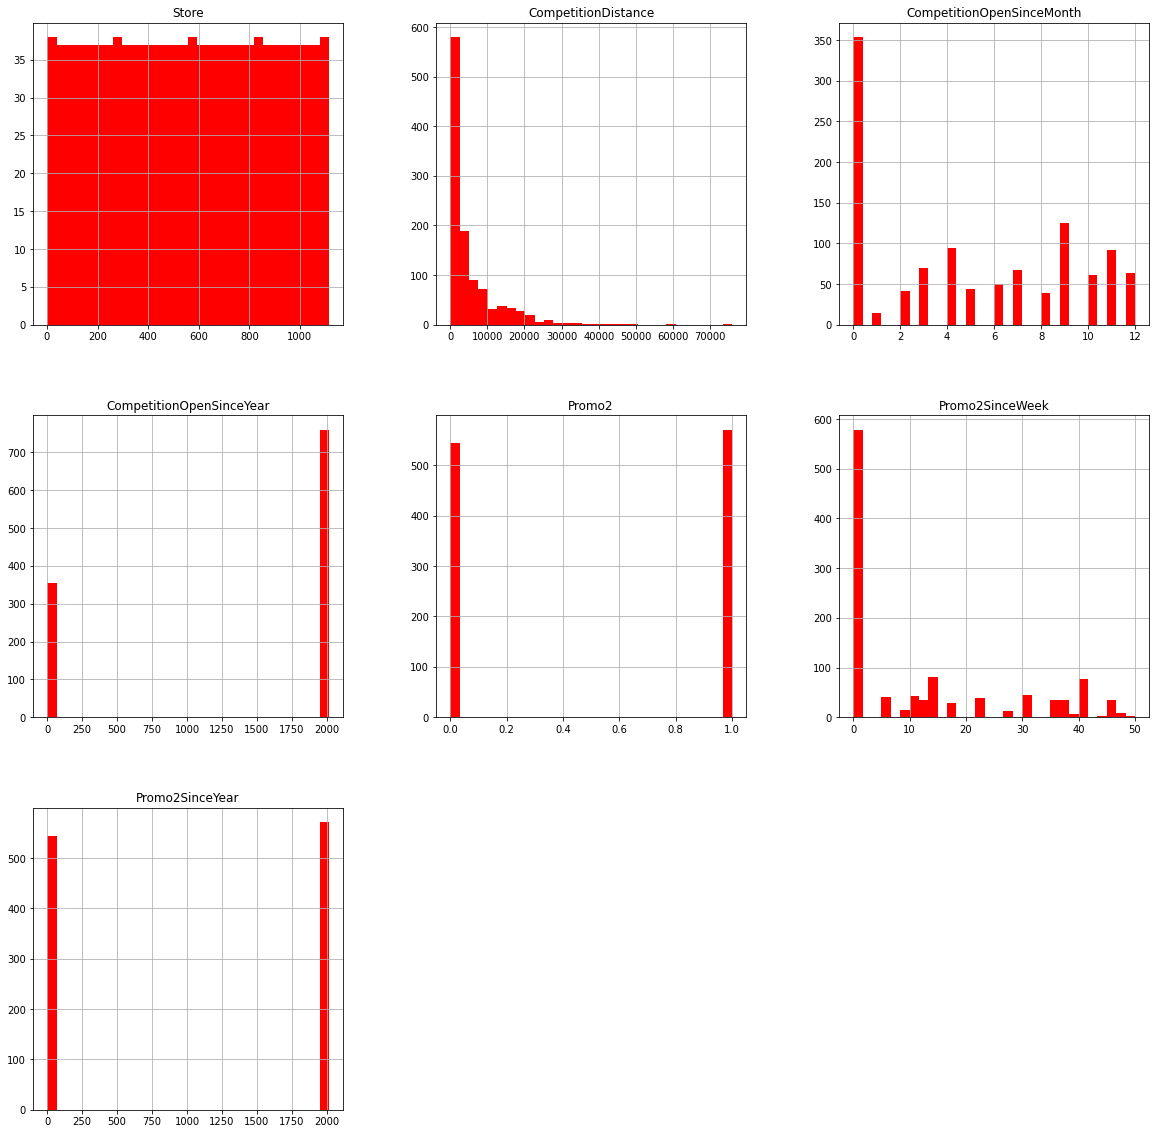

In [27]:
# Now we got rid of the missing values, Let's look at histograms
store_info_df.hist(bins=30, figsize=(20,20), color='r')
plt.show()

*   half of stores are involved in promo 2
*   half of the stores have their competition at a distance of 0-3 km

### MERGE TWO DATASET AND EXPLORE

In [28]:
# Let's merge both data frames together based on 'store'
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how='inner', on='Store')

In [29]:
# Let's look the correlations of features with Sales
sales_train_all_df.corr()['Sales'].sort_values(ascending=False)

Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
SchoolHoliday                0.038617
Store                        0.007710
CompetitionOpenSinceYear     0.005266
CompetitionOpenSinceMonth   -0.018370
CompetitionDistance         -0.036343
Promo2SinceWeek             -0.058476
Promo2                      -0.127596
Promo2SinceYear             -0.127621
DayOfWeek                   -0.178736
Name: Sales, dtype: float64

*   Customers and Promo are positively correlated with the sales 
*   Promo2 does not seem to be effective at all 

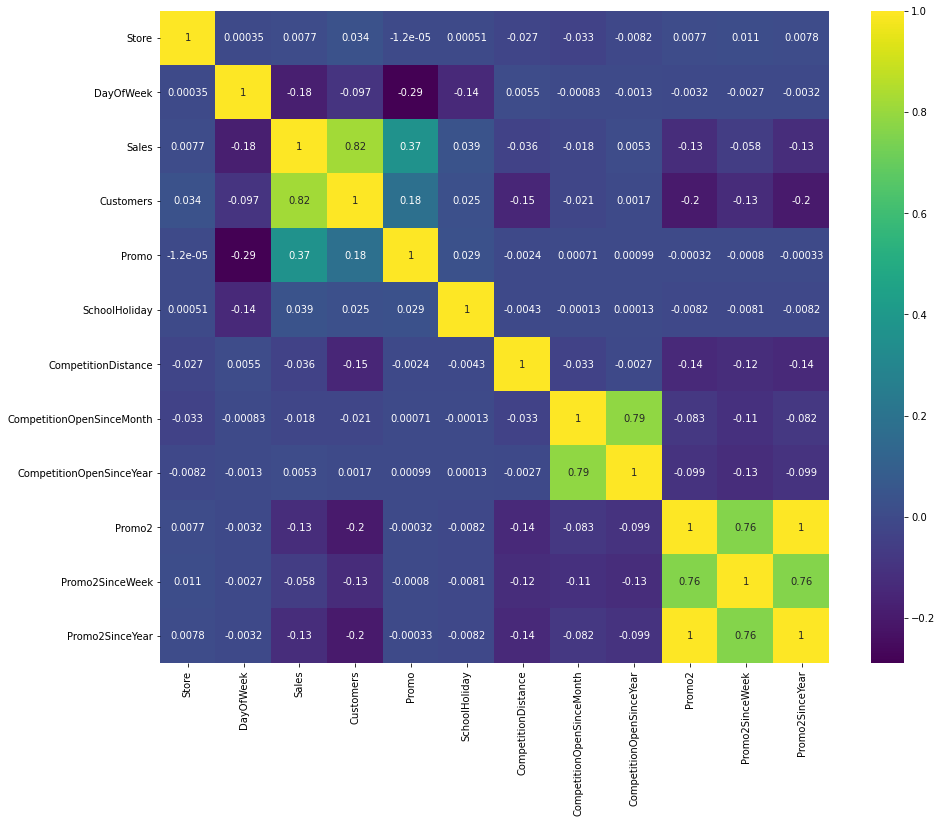

In [30]:
# Let's look at the all correlations
plt.subplots(figsize = (15, 12))
sns.heatmap(sales_train_all_df.corr(), annot = True, cmap='viridis')

In [31]:
# Let's separate the year, month and day of 'Date' column and put them into a separate column 
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

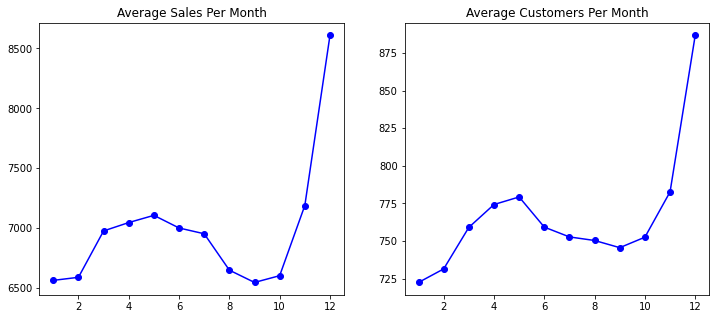

In [32]:
# Let's take a look at the average sales and number of customers per month
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(sales_train_all_df.groupby('Month')['Sales'].mean(), marker = 'o', color = 'b')
ax1.set_title('Average Sales Per Month')
ax2.plot(sales_train_all_df.groupby('Month')['Customers'].mean(), marker = 'o', color = 'b')
ax2.set_title('Average Customers Per Month')
plt.show()

*   It looks like sales and number of customers peak around christmas timeframe

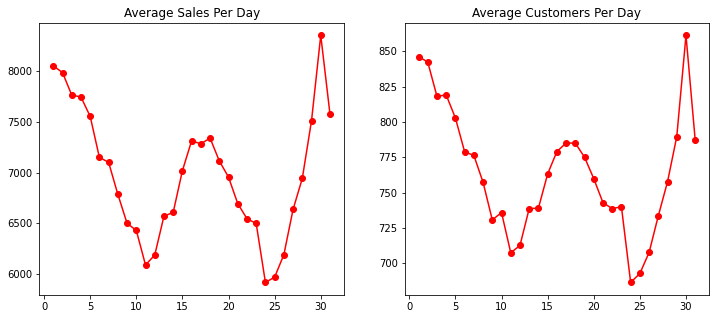

In [33]:
# Let's take a look at the sales and customers per day
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(sales_train_all_df.groupby('Day')['Sales'].mean(), marker = 'o', color = 'r')
ax1.set_title('Average Sales Per Day')
ax2.plot(sales_train_all_df.groupby('Day')['Customers'].mean(), marker = 'o', color = 'r')
ax2.set_title('Average Customers Per Day')
plt.show()

*   Most customers and sales are around at the end and at the beginning of the month
*   Minimum number of customers are generally around the 24th of the month 

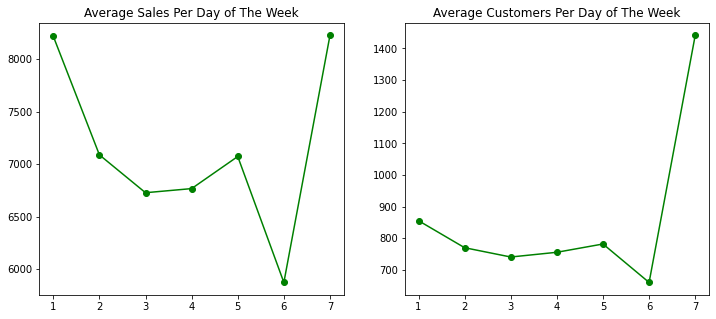

In [34]:
# Let's do the same for the day of the week
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(sales_train_all_df.groupby('DayOfWeek')['Sales'].mean(), marker = 'o', color = 'g')
ax1.set_title('Average Sales Per Day of The Week')
ax2.plot(sales_train_all_df.groupby('DayOfWeek')['Customers'].mean(), marker = 'o', color = 'g')
ax2.set_title('Average Customers Per Day of The Week')
plt.show()

*   Actual peak of the sales happen around Sunday's.

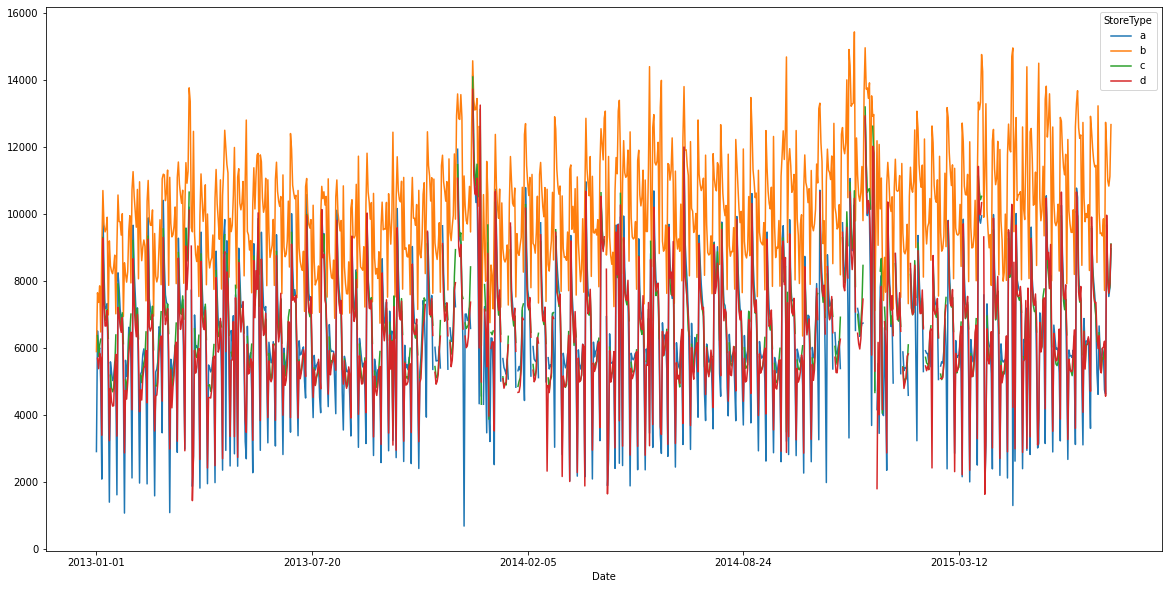

In [35]:
# Let's look at the average sales of each Store Type
fig, ax = plt.subplots(figsize=(20,10))
sales_train_all_df.groupby(['Date','StoreType'])['Sales'].mean().unstack().plot(ax=ax)
plt.show()

*   It seems Store B has highest value of average Sales.

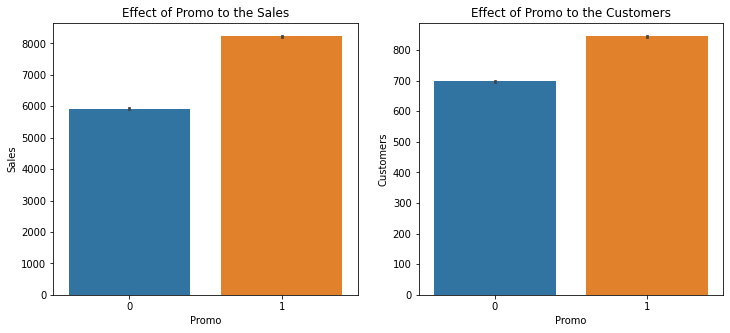

In [36]:
# Let's look at the effect of Promotions to the Sales/Customers
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.barplot(x='Promo', y='Sales', data=sales_train_all_df, ax=ax1)
ax1.set_title('Effect of Promo to the Sales')
sns.barplot(x='Promo', y='Customers', data=sales_train_all_df, ax=ax2)
ax2.set_title('Effect of Promo to the Customers')
plt.show()

*   It seems that promotions has increased the total sales and total customers

# TRAIN THE MODEL

In [38]:
from fbprophet import Prophet

In [40]:
def sales_prediction(Store_ID, sales_df, holidays, periods):
# This Function takes in the data frame, storeID, holidays and number of future period forecast
# Then arranges date/sales columns available to Prophet format
# And then makes time series predictions

    sales_df = sales_df[sales_df['Store'] == Store_ID]
    sales_df = sales_df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
    sales_df = sales_df.sort_values('ds')
  
    model = Prophet(holidays=holidays)
    model.fit(sales_df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    figure1  = model.plot(forecast, xlabel='Date', ylabel='Sales')
    figure2  = model.plot_components(forecast)

*  To pass the holidays in the correct format:

In [41]:
# Get all the dates pertaining to school holidays 
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday'] == 1]['Date'].unique()
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})

In [42]:
# Get all the dates pertaining to state holidays 
state_holidays = sales_train_all_df[sales_train_all_df['StateHoliday'].isin(['a', 'b', 'c'])].loc[:, 'Date'].unique()
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                               'holiday': 'state_holiday'})

In [43]:
# concatenate both school and state holidays 
holidays = pd.concat([school_holidays, state_holidays])
holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
30,2014-11-01,state_holiday
31,2013-11-01,state_holiday
32,2015-01-06,state_holiday
33,2014-01-06,state_holiday


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


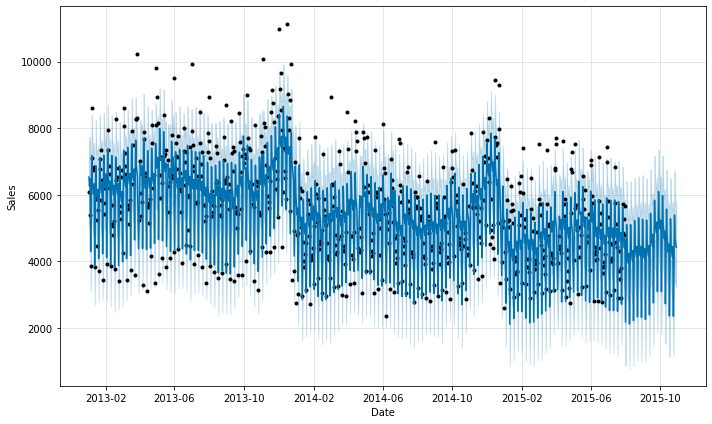

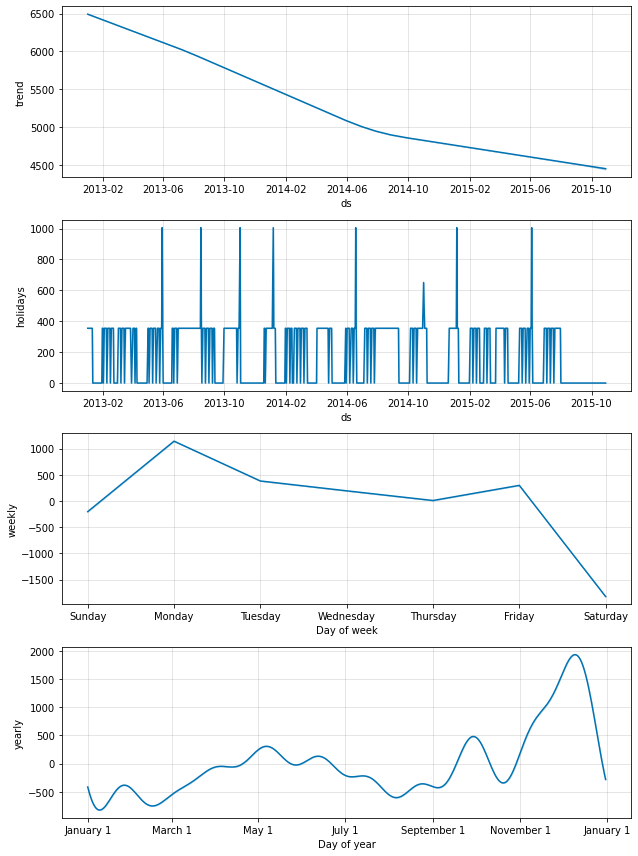

In [44]:
# Now we can make predictions for as specific store for a specific period of time that we want passing the holidays information.
sales_prediction(6, sales_train_all_df, holidays, 90)

*   The general sales trend is going down for that specific store
*   There are spikes occuring during the holidays
*   Most of the sales happen around December timeframe (due to Christmas)